In [18]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import scipy.io
import time
import numpy as np
from Function.ReceptiveField import *
from Function.SNNModule_v3 import *
from Function.plot_SNN import *
from Function.SNN_230418 import *
from Function.Stimulation_GPU import *
%matplotlib inline
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [19]:
# Check if GPU is available and print the CUDA version
print(f"GPU available: {torch.cuda.is_available()}")
print(f"CUDA version: {torch.version.cuda}")

# Enable GPU support if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Set the device to 'cpu'
device = 'cpu'

print(f"Using device: {device}")
# Start of the SNN (Spiking Neural Network) code


GPU available: True
CUDA version: 10.1
Using device: cpu


In [20]:
# Set sensor dimensions (height and width in millimeters)
sensor_h, sensor_w = 19, 16

# Set pixel dimensions (number of pixels in height and width)
pixel_h, pixel_w = 64, 48

# Set image frames per second (FPS) of tactile sensor
image_FPS = 60

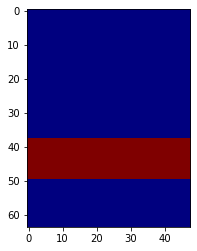

cpu


In [21]:
num_stim = 1000
stimulation_horizontal_below = torch.zeros((pixel_h, pixel_w, num_stim), device=device)
stimulation_horizontal_above = torch.zeros((pixel_h, pixel_w, num_stim), device=device)
max_F = 7
F_array = np.concatenate([
    np.zeros((100,)),
    np.linspace(0, max_F, 200),
    np.full((400,), max_F),
    np.linspace(max_F, 0, 200),
    np.zeros((100,))
])
for i, F_i in enumerate(F_array):
    horizontal_below = elongated_stim_v2(F=F_i*2, pixel_h=pixel_h,
                              pixel_w=pixel_w, position='below', orientation='horizontal')
    horizontal_above = elongated_stim_v2(F=F_i*2, pixel_h=pixel_h,
                              pixel_w=pixel_w, position='above', orientation='horizontal')
    # Use 'vertical' for vertically elongated stimulus
    # stim_dot = elongated_stim(F=F_i, pixel_h=pixel_h, pixel_w=pixel_w, orientation='vertical')
    stimulation_horizontal_below[:, :, i] = horizontal_below
    stimulation_horizontal_above[:, :, i] = horizontal_above
    if i ==600:
        plt.imshow(stimulation_horizontal_below[:, :, i].cpu(),
                   cmap='jet', vmin=0, vmax=max_F)

        plt.show()
print(stimulation_horizontal_below.device)



In [17]:
# Generate Slowly Adapting (SA) and Rapidly Adapting (RA) receptive fields
SA_RF, [SA_step_height, SA_step_width] = generate_mechanoreceptor_to_afferent_rf(
    kernel_w=11, kernel_h=10, step_size=6, device=device)
RA_RF, [RA_step_height, RA_step_width] = generate_mechanoreceptor_to_afferent_rf(
    kernel_w=15, kernel_h=14, step_size=6, device=device)

# Print the shape of the SA_rf variable
print("SA_rf shape:", SA_RF.shape, 'with height =',
      SA_step_height, 'with width =', SA_step_width)
print("RA_rf shape:", RA_RF.shape, 'with height =',
      RA_step_height, 'with width =', RA_step_width)

# Define optimized receptive fields
CN_PN_RF = [
    torch.tensor([[0, 0, 0], [0, 1, 0], [0, 0, 0]],
                 device=device) * 10, 
]

CN_IN_RF = [
    torch.tensor([[1, 1, 1], [1, 0, 1], [1, 1, 1]],
                 device=device) * 5,  
    # torch.tensor([[1, 1, 1], [1, 0, 1], [1, 1, 1]],
                #  device=device) * 5,
]

# Define synaptic delays
CN_SD = [
    torch.tensor([[2, 2, 2], [2, 2, 2], [2, 2, 2]], device=device),
]

# # Define optimized receptive fields
# CN_PN_RF = [
#     torch.tensor([[0, 0, 1, 0, 0],
#                   [0, 1, 2, 1, 0],
#                   [1, 2, 4, 2, 1],
#                   [0, 1, 2, 1, 0],
#                   [0, 0, 1, 0, 0]], device=device) * 5,  # Example RF
# ]

# CN_IN_RF = [
#     torch.tensor([[1, 1, 1, 1, 1],
#                   [1, 0, 0, 0, 1],
#                   [1, 0, 0, 0, 1],
#                   [1, 0, 0, 0, 1],
#                   [1, 1, 1, 1, 1]], device=device) * 5,  # Example RF
# ]

# # Define synaptic delays
# CN_SD = [
#     torch.tensor([[0, 0, 0, 0, 0],
#                   [0, 0, 0, 0, 0],
#                   [0, 0, 0, 0, 0],
#                   [0, 0, 0, 0, 0],
#                   [0, 0, 0, 0, 0]], device=device),
# ]

# Check if the sizes of the inner tensors are different and print the index
for i, (PN, IN) in enumerate(zip(CN_PN_RF, CN_IN_RF)):
    if PN.size() != IN.size():
        raise ValueError(
            f"The inner tensors at index {i} have different sizes: {PN.size()} != {IN.size()}")

SA_CN_PN_RF, SA_CN_PN_RF_len = generate_afferent_to_top_rf(CN_PN_RF, pixel_h=SA_step_height,
                                                           pixel_w=SA_step_width, step_size=1, device=device)
SA_CN_IN_RF, SA_CN_IN_RF_len = generate_afferent_to_top_rf(CN_IN_RF, pixel_h=SA_step_height,
                                                           pixel_w=SA_step_width, step_size=1, device=device)
SA_CN_SD, SA_CN_SD_len = generate_afferent_to_top_rf(CN_SD, pixel_h=SA_step_height,
                                                     pixel_w=SA_step_width, step_size=1, device=device)


RA_CN_PN_RF, RA_CN_PN_RF_len = generate_afferent_to_top_rf(CN_PN_RF, pixel_h=RA_step_height,
                                                           pixel_w=RA_step_width, step_size=1, device=device)
RA_CN_IN_RF, RA_CN_IN_RF_len = generate_afferent_to_top_rf(CN_IN_RF, pixel_h=RA_step_height,
                                                           pixel_w=RA_step_width, step_size=1, device=device)
RA_CN_SD, RA_CN_SD_len = generate_afferent_to_top_rf(CN_SD, pixel_h=RA_step_height,
                                                     pixel_w=RA_step_width, step_size=1, device=device)

print(len(SA_RF), len(SA_CN_PN_RF), len(SA_CN_IN_RF))
# 3rd integration layer
num_output_neuron = 50
CN_PN_RF, CN_PN_DN = create_weight_matrix(len(SA_CN_PN_RF)+len(RA_CN_PN_RF),num_output_neuron,connection_probability = 0.2, device = device)
CN_IN_RF, CN_IN_DN = create_weight_matrix(len(SA_CN_PN_RF)+len(RA_CN_PN_RF),num_output_neuron,connection_probability = 0.2, device = device)

print(len(CN_PN_RF),len(CN_IN_RF))

Complete! Generated 70 receptive fields from mechanoreceptor to afferents with kernel size 10x11.
Complete! Generated 54 receptive fields from mechanoreceptor to afferents with kernel size 14x15.
SA_rf shape: torch.Size([70, 3072]) with height = 10 with width = 7
RA_rf shape: torch.Size([54, 3072]) with height = 9 with width = 6
Complete! Generated 40 receptive fields from afferents to the top with kernel size 3x3. with step size 8x5
Complete! Generated 40 receptive fields from afferents to the top with kernel size 3x3. with step size 8x5
Complete! Generated 40 receptive fields from afferents to the top with kernel size 3x3. with step size 8x5
Complete! Generated 28 receptive fields from afferents to the top with kernel size 3x3. with step size 7x4
Complete! Generated 28 receptive fields from afferents to the top with kernel size 3x3. with step size 7x4
Complete! Generated 28 receptive fields from afferents to the top with kernel size 3x3. with step size 7x4
70 40 40
50 50


In [14]:
# Create Izhikevich layers
SA_layer = IzhikevichLayer(
    0.02, 0.2, -65, 8, len(SA_RF),v_thres=30, a_decay=1.01,noise_std = 0, device=device)
SA_CN_PN_layer = IzhikevichLayer(
    0.02, 0.2, -65, 8, len(SA_CN_PN_RF),v_thres=30, a_decay=1, noise_std = 0, device=device)
SA_CN_IN_layer = IzhikevichLayer(
    0.1, 0.2, -70, 2, len(SA_CN_IN_RF),v_thres=30, a_decay=1, noise_std = 0, device=device)

RA_layer = IzhikevichLayer(
    0.02, 0.2, -65, 8, len(RA_RF),v_thres=30, a_decay=1, noise_std = 0,device=device)
RA_CN_PN_layer = IzhikevichLayer(
    0.1, 0.2, -65, 6, len(RA_CN_PN_RF),v_thres=30, a_decay=1,noise_std = 0, device=device)
RA_CN_IN_layer = IzhikevichLayer(
    0.02, 0.25, -65, 6, len(RA_CN_IN_RF), v_thres=30, a_decay=1, noise_std=0, device=device)

SA_layers = [SA_layer, SA_CN_PN_layer, SA_CN_IN_layer]
RA_layers = [RA_layer, RA_CN_PN_layer, RA_CN_IN_layer]

SA_synapse = Synapse(SA_RF.to(device), device=device)
SA_CN_PN_synapse = Synapse(SA_CN_PN_RF.to(
    device), delays=SA_CN_SD, device=device)
SA_CN_IN_synapse = Synapse(SA_CN_IN_RF.to(
    device), delays=SA_CN_SD, device=device)

RA_synapse = Synapse(RA_RF.to(device), device=device)
RA_CN_PN_synapse = Synapse(RA_CN_PN_RF.to(
    device), delays=RA_CN_SD, device=device)
RA_CN_IN_synapse = Synapse(RA_CN_IN_RF.to(
    device), delays=RA_CN_SD, device=device)

SA_synapses = [SA_synapse, SA_CN_PN_synapse, SA_CN_IN_synapse]
RA_synapses = [RA_synapse, RA_CN_PN_synapse, RA_CN_IN_synapse]

# 3rd layer 

CN_PN_layer = IzhikevichLayer(
    0.02, 0.2, -65, 8, len(CN_PN_RF),v_thres=30, a_decay=1, device=device)
CN_IN_layer = IzhikevichLayer(
    0.1, 0.2, -65, 2, len(CN_IN_RF), v_thres=30, a_decay=1, device=device)

CN_PN_synapse = Synapse(CN_PN_RF.to(
    device), delays=CN_PN_DN, device=device)
CN_IN_synapse = Synapse(CN_IN_RF.to(
    device), delays=CN_IN_DN, device=device)

CN_layers = [CN_PN_layer, CN_IN_layer]
CN_synapses = [CN_PN_synapse,CN_IN_synapse]



layers initialized
layers initialized
layers initialized
layers initialized
layers initialized
layers initialized
Synapses initialized
Synapses initialized
Synapses initialized
Synapses initialized
Synapses initialized
Synapses initialized
layers initialized
layers initialized
Synapses initialized
Synapses initialized


start feedforward
[[], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [137, 178, 209, 235, 258, 279, 298, 319, 342, 365, 388, 411, 434, 458, 482, 506, 530, 554, 579, 604, 629, 654, 679, 705, 747], [], [], [], [], [], [168, 227, 271, 309, 353, 397, 441, 486, 532, 578, 624, 670, 722], [112, 124, 134, 143, 151, 159, 166, 173, 179, 185, 191, 197, 202, 208, 213, 218, 223, 228, 233, 238, 242, 246, 251, 255, 259, 263, 267, 271, 275, 279, 283, 287, 291, 295, 299, 303, 308, 313, 318, 323, 328, 333, 338, 344, 349, 355, 360, 366, 372, 377, 383, 389, 395, 401, 407, 413, 419, 425, 431, 437, 444, 450, 456, 463, 469, 476, 483, 489, 496, 503, 510, 517, 524, 531, 538, 545, 553, 560, 568, 575, 583, 590, 598, 606, 614, 622, 630, 638, 646, 654, 663, 671, 680, 688, 697, 707, 740], [110, 119, 127, 135, 142, 148, 154, 160, 165, 170, 175, 180, 185, 189, 194, 198, 202, 206, 210, 214, 218, 222, 226, 230, 234, 238, 241, 245,

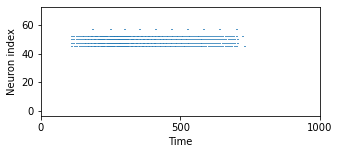

torch.Size([70])
torch.Size([10, 7])


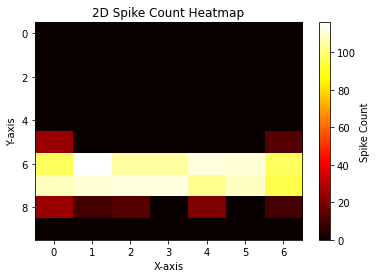

[[], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], []]


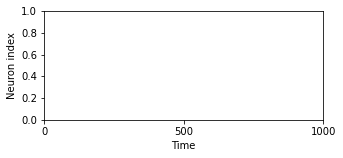

torch.Size([40])
torch.Size([8, 5])


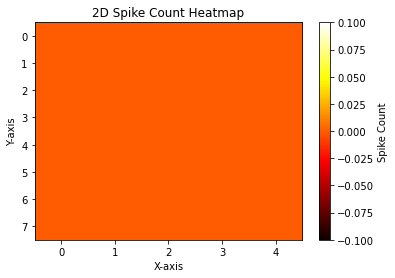

[[], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [281], [], [], [], [], [], [], [], [], [], [], [], [], [], []]


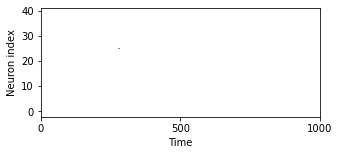

torch.Size([40])
torch.Size([8, 5])


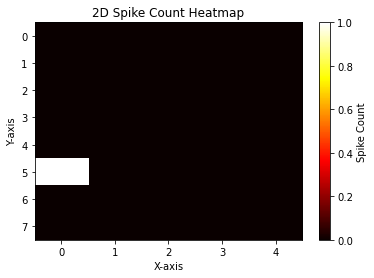

[[], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [107, 183, 270, 707, 783, 870], [103, 108, 127, 156, 185, 214, 243, 272, 703, 708, 727, 756, 785, 814, 843, 872], [103, 111, 144, 180, 216, 252, 288, 703, 710, 743, 779, 815, 851, 887], [106, 159, 226, 293, 706, 759, 827, 895], [107, 179, 262, 707, 779, 862], [105, 153, 218, 283, 705, 753, 818, 883], [102, 105, 109, 115, 127, 143, 159, 175, 191, 207, 223, 239, 255, 271, 287, 702, 705, 709, 715, 727, 743, 759, 775, 791, 807, 823, 839, 855, 871, 887], [102, 105, 110, 120, 139, 158, 177, 196, 215, 234, 253, 272, 291, 702, 705, 710, 720, 739, 758, 777, 796, 815, 834, 853, 872, 891], [102, 105, 110, 121, 140, 159, 178, 197, 216, 235, 254, 273, 292, 702, 705, 710, 721, 740, 759, 778, 797, 816, 835, 854, 873, 892], [102, 105, 109, 116, 132, 149, 166, 183, 200, 217, 234, 251, 268, 285, 702, 705, 709, 716, 732, 749, 766, 783, 800, 817, 834, 851, 868, 885], [102, 105, 109, 116

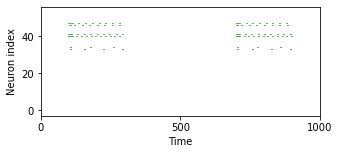

torch.Size([54])
torch.Size([9, 6])


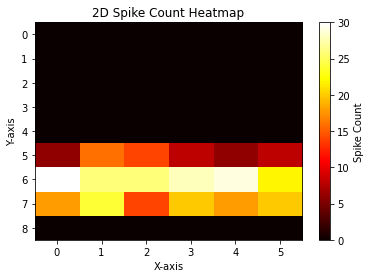

[[], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [110, 196, 283, 710, 796, 883], [110, 191, 297, 710, 791, 896], [113, 234, 713, 835], [114, 191, 273, 714, 791, 873], [109, 210, 304, 709, 810, 904], [109, 208, 304, 709, 808, 904], [109, 200, 299, 709, 800, 899], [109, 201, 298, 709, 804, 898], [109, 203, 296, 709, 803, 896], [110, 193, 302, 710, 793, 902], [109, 201, 302, 709, 800, 901], [110, 191, 294, 710, 791, 894]]


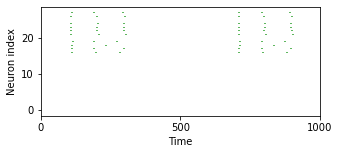

torch.Size([28])
torch.Size([7, 4])


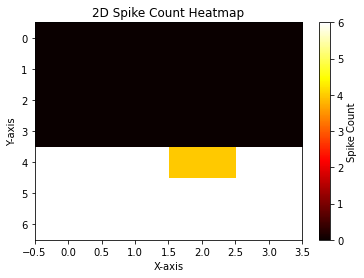

[[], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [109, 134, 163, 192, 221, 250, 279, 709, 734, 763, 792, 821, 850, 879], [109, 150, 186, 222, 258, 294, 709, 749, 785, 821, 857, 893], [165, 232, 300, 765, 833, 902], [185, 268, 785, 868], [108, 146, 169, 203, 226, 260, 298, 708, 746, 769, 803, 826, 860, 899], [108, 131, 166, 205, 242, 266, 300, 708, 731, 766, 805, 842, 865, 900], [108, 139, 173, 207, 241, 275, 708, 739, 773, 807, 841, 875], [108, 138, 172, 209, 240, 274, 708, 737, 771, 807, 839, 873, 909], [108, 135, 157, 179, 218, 241, 264, 304, 708, 735, 757, 779, 818, 842, 882], [109, 151, 188, 225, 262, 300, 709, 751, 788, 825, 862, 900], [108, 147, 173, 199, 223, 248, 273, 299, 708, 746, 772, 798, 822, 847, 872, 897], [109, 131, 156, 183, 210, 237, 264, 291, 709, 731, 756, 783, 810, 837, 864, 891]]


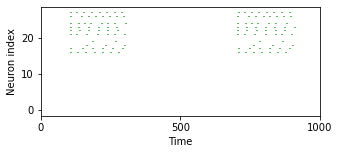

torch.Size([28])
torch.Size([7, 4])


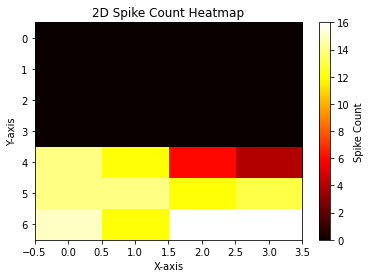

[[118, 712], [118, 715], [], [], [232], [113], [], [112, 713], [], [], [], [], [], [], [], [111, 246, 711, 853], [], [], [], [741], [], [112, 712], [], [], [], [], [], [110, 178, 279, 710, 781, 878], [], [812], [], [111, 247, 711], [], [113], [], [], [], [], [], [], [113, 715], [], [], [119, 304, 711, 906], [111, 712, 825], [], [778], [], [], [115, 716]]


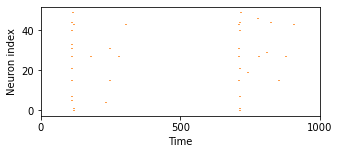

[[111, 137, 712, 790, 869], [], [113, 191, 229, 712, 793, 826], [], [114, 215, 713], [], [309], [], [], [], [808], [], [], [], [], [], [112, 713, 750, 828], [307], [], [], [113, 714, 751], [], [], [], [], [], [], [], [], [], [], [], [882], [], [225], [], [], [], [112, 712], [], [], [876], [115, 715], [113], [], [], [], [829], [], []]


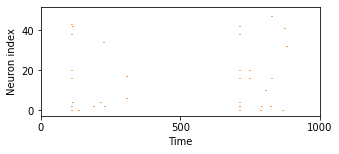

In [15]:
S = SNNModel([SA_layers,RA_layers,CN_layers],[SA_synapses,RA_synapses,CN_synapses],device)

S.feedforward(stimulation_horizontal_below)

fig_size = (5,2)
plot_spike_times(S.SA_spike_times[0], size=fig_size, colors='tab:blue')
plot_total_spike_2D(S.SA_spike_times[0], size=(10,7))
# plot_firing_rates(S.SA_spike_times[0])
plot_spike_times(S.SA_spike_times[2], size=fig_size, colors='tab:blue')
plot_total_spike_2D(S.SA_spike_times[2], size=(8,5))
plot_spike_times(S.SA_spike_times[1], size=fig_size, colors='tab:blue')
plot_total_spike_2D(S.SA_spike_times[1], size=(8, 5))
# plot_total_spike_2D(S.SA_spike_times[1], size=(7,4))

plot_spike_times(S.RA_spike_times[0], size=fig_size, colors='tab:green')
plot_total_spike_2D(S.RA_spike_times[0], size=(9,6))
plot_spike_times(S.RA_spike_times[2], size=fig_size, colors='tab:green')
plot_total_spike_2D(S.RA_spike_times[2], size=(7,4))
plot_spike_times(S.RA_spike_times[1], size=fig_size, colors='tab:green')
plot_total_spike_2D(S.RA_spike_times[1], size=(7,4))

plot_spike_times(S.CN_spike_times[0], size=fig_size, colors='tab:orange')
plot_spike_times(S.CN_spike_times[1], size=fig_size, colors='tab:orange')
# print(torch.sum(S.CN_spike_times[1]))


start feedforward
[[278, 409, 544, 680], [187, 253, 303, 358, 415, 473, 531, 589, 647, 706], [157, 211, 252, 286, 319, 356, 393, 430, 468, 506, 544, 583, 622, 661, 701, 771], [], [163, 220, 263, 299, 339, 380, 421, 463, 505, 547, 590, 633, 676, 727], [162, 218, 260, 295, 333, 373, 413, 454, 495, 536, 578, 620, 662, 705, 812], [], [110, 120, 129, 137, 144, 151, 157, 163, 169, 174, 179, 184, 189, 194, 199, 203, 207, 212, 216, 220, 224, 228, 232, 236, 240, 244, 248, 252, 255, 259, 262, 266, 269, 273, 276, 279, 283, 286, 289, 292, 296, 299, 303, 307, 311, 315, 319, 323, 328, 332, 337, 342, 347, 351, 356, 361, 366, 371, 376, 381, 386, 391, 396, 401, 406, 411, 417, 422, 428, 433, 439, 445, 450, 456, 462, 468, 474, 480, 486, 492, 498, 504, 510, 516, 523, 529, 535, 542, 549, 555, 562, 569, 576, 583, 590, 597, 604, 611, 618, 625, 633, 640, 648, 655, 663, 671, 678, 686, 694, 702, 733], [111, 123, 133, 141, 149, 156, 163, 170, 176, 182, 188, 193, 198, 203, 208, 213, 218, 223, 227, 232, 236, 240, 

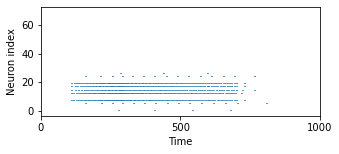

torch.Size([70])
torch.Size([10, 7])


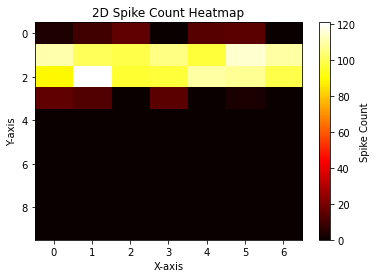

[[], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], []]


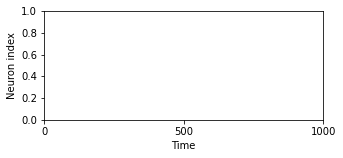

torch.Size([40])
torch.Size([8, 5])


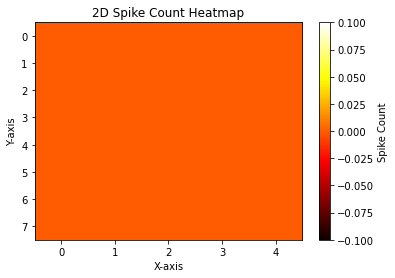

[[], [], [], [], [299], [262], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], []]


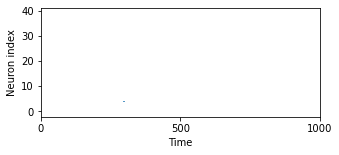

torch.Size([40])
torch.Size([8, 5])


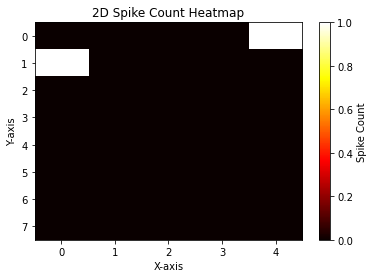

[[104, 117, 159, 201, 243, 285, 704, 717, 759, 801, 843, 885], [103, 108, 128, 157, 186, 215, 244, 273, 703, 708, 728, 757, 786, 815, 844, 873], [105, 154, 220, 285, 705, 753, 818, 883], [104, 127, 175, 223, 271, 704, 727, 775, 823, 871], [103, 111, 145, 182, 219, 256, 293, 703, 711, 745, 782, 819, 856, 893], [105, 142, 198, 253, 705, 741, 797, 853], [102, 105, 108, 113, 121, 136, 151, 166, 181, 196, 211, 226, 241, 256, 271, 286, 702, 705, 708, 713, 721, 736, 751, 766, 781, 796, 811, 826, 841, 856, 871, 886], [102, 105, 110, 120, 139, 158, 177, 196, 215, 234, 253, 272, 291, 702, 705, 710, 719, 738, 757, 776, 795, 814, 833, 852, 871, 890], [102, 105, 110, 120, 139, 158, 177, 196, 215, 234, 253, 272, 291, 702, 705, 710, 720, 739, 758, 777, 796, 815, 834, 853, 872, 891], [102, 106, 113, 133, 156, 179, 202, 225, 248, 271, 294, 702, 706, 713, 733, 756, 779, 802, 825, 848, 871, 894], [102, 105, 110, 120, 139, 158, 177, 196, 215, 234, 253, 272, 291, 702, 705, 710, 720, 739, 758, 777, 796, 815

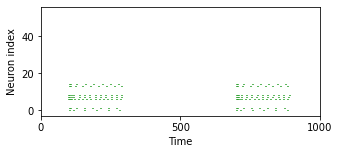

torch.Size([54])
torch.Size([9, 6])


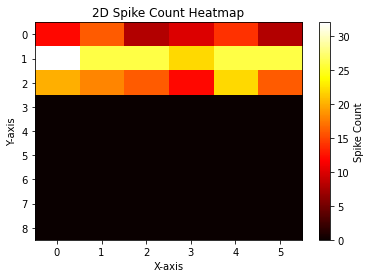

[[109, 210, 304, 709, 808, 903], [109, 210, 304, 709, 810, 904], [109, 192, 282, 709, 792, 882], [109, 210, 304, 709, 810, 904], [110, 192, 277, 710, 792, 898], [110, 201, 291, 710, 799, 889], [110, 198, 280, 710, 798, 880], [109, 212, 301, 709, 812, 901], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], []]


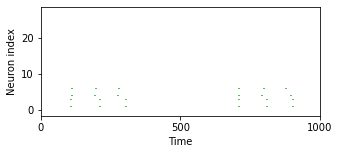

torch.Size([28])
torch.Size([7, 4])


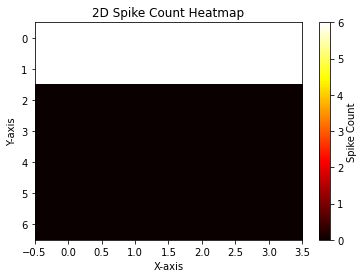

[[108, 146, 170, 203, 225, 260, 298, 708, 745, 786, 820, 841, 878, 902], [108, 146, 170, 203, 225, 260, 298, 708, 746, 770, 804, 841, 867, 898], [108, 140, 164, 187, 210, 233, 256, 279, 302, 708, 740, 764, 787, 810, 833, 856, 879, 902], [108, 146, 170, 203, 225, 260, 298, 708, 746, 770, 804, 841, 867, 898], [109, 132, 159, 187, 242, 271, 299, 709, 732, 759, 786, 814, 840, 867, 894], [109, 138, 168, 198, 228, 258, 288, 709, 736, 766, 796, 826, 856, 886], [109, 155, 194, 233, 272, 709, 755, 794, 833, 872], [108, 138, 161, 184, 226, 249, 271, 293, 708, 738, 761, 784, 825, 848, 871, 894], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], []]


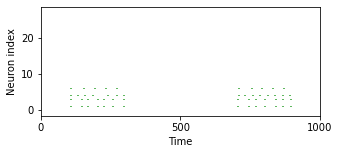

torch.Size([28])
torch.Size([7, 4])


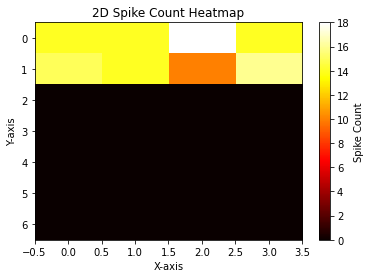

[[114, 241, 837], [], [146], [113], [743], [], [], [], [], [], [], [], [718], [], [], [], [864], [], [], [], [], [], [], [], [], [211, 713], [], [], [], [], [], [118, 712], [], [], [115], [808], [], [], [713], [], [], [], [112], [198], [], [144], [714], [], [], []]


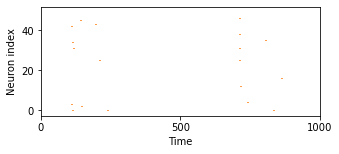

[[306], [], [], [], [113, 151, 264, 711, 848], [], [], [], [], [], [], [], [], [], [306], [], [], [], [110, 152, 207, 229, 263, 302, 710, 753, 832, 907], [], [], [714], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [111, 154, 306, 712, 863, 907], [], [], [], [], [113, 231, 711], [], [], [], [], []]


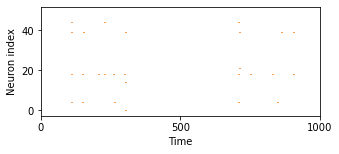

In [16]:
S = SNNModel([SA_layers,RA_layers,CN_layers],[SA_synapses,RA_synapses,CN_synapses],device)

S.feedforward(stimulation_horizontal_above)

fig_size = (5, 2)
plot_spike_times(S.SA_spike_times[0], size=fig_size, colors='tab:blue')
plot_total_spike_2D(S.SA_spike_times[0], size=(10, 7))
plot_spike_times(S.SA_spike_times[2], size=fig_size, colors='tab:blue')
plot_total_spike_2D(S.SA_spike_times[2], size=(8, 5))
plot_spike_times(S.SA_spike_times[1], size=fig_size, colors='tab:blue')
plot_total_spike_2D(S.SA_spike_times[1], size=(8, 5))
# plot_total_spike_2D(S.SA_spike_times[1], size=(7,4))

plot_spike_times(S.RA_spike_times[0], size=fig_size, colors='tab:green')
plot_total_spike_2D(S.RA_spike_times[0], size=(9, 6))
plot_spike_times(S.RA_spike_times[2], size=fig_size, colors='tab:green')
plot_total_spike_2D(S.RA_spike_times[2], size=(7, 4))
plot_spike_times(S.RA_spike_times[1], size=fig_size, colors='tab:green')
plot_total_spike_2D(S.RA_spike_times[1], size=(7, 4))

plot_spike_times(S.CN_spike_times[0], size=fig_size, colors='tab:orange')
plot_spike_times(S.CN_spike_times[1], size=fig_size, colors='tab:orange')
# print(torch.sum(S.CN_spike_times[1]))
